In [68]:
import pickle
import os

from datetime import datetime
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import OrdinalEncoder
import sklearn
from sklearn import set_config


import xgboost as xgb

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

In [69]:
set_config(transform_output = "pandas")

In [70]:
df = pd.read_csv(r'./data_dsmarket/preproc_data/full_df.csv')

In [71]:
df = df.rename(columns={col: col.upper() for col in df.columns})

In [72]:
df.head()

,UNNAMED: 0,ID,DATE,ITEM,CATEGORY,DEPARTMENT,STORE_CODE,REGION,STORE,SALES_COUNT,EVENT_NEWYEAR,EVENT_NONE,EVENT_SUPERBOWL,EVENT_THANKSGIVING,EVENT_RAMADAN,SELL_PRICE,REVENUE
0,0,ACCESORIES_1_001_NYC_1,2011-02-06,ACCESORIES_1_001,ACCESORIES,ACCESORIES_1,NYC_1,New York,Greenwich_Village,0,False,False,True,False,False,NaN,NaN
1,1,ACCESORIES_1_001_NYC_1,2011-02-13,ACCESORIES_1_001,ACCESORIES,ACCESORIES_1,NYC_1,New York,Greenwich_Village,0,False,False,False,False,False,NaN,NaN
2,2,ACCESORIES_1_001_NYC_1,2011-02-20,ACCESORIES_1_001,ACCESORIES,ACCESORIES_1,NYC_1,New York,Greenwich_Village,0,False,False,False,False,False,NaN,NaN
3,3,ACCESORIES_1_001_NYC_1,2011-02-27,ACCESORIES_1_001,ACCESORIES,ACCESORIES_1,NYC_1,New York,Greenwich_Village,0,False,False,False,False,False,NaN,NaN
4,4,ACCESORIES_1_001_NYC_1,2011-03-06,ACCESORIES_1_001,ACCESORIES,ACCESORIES_1,NYC_1,New York,Greenwich_Village,0,False,False,False,False,False,NaN,NaN


In [73]:
ORDER_COLUMNS = [
    'DATE',
    'ID',
    'ITEM',
    'ITEM_ID',
    'ITEM_CATEGORY',
    'ITEM_CATEGORY_ID',
    'ITEM_DEPARTMENT',
    'ITEM_DEPARTMENT_ID',
    'STORE_CODE',
    'REGION',
    'REGION_ID',
    'STORE',
    'STORE_ID',
    'SALES_COUNT',
    'SELL_PRICE',
    'REVENUE',
    'EVENT_NEWYEAR',
    'EVENT_NONE',
    'EVENT_SUPERBOWL',
    'EVENT_THANKSGIVING',
    'EVENT_RAMADAN'
]

In [74]:
def preprocess_df(df):
    df.columns = map(str.upper, df.columns)
    df['DATE'] = pd.to_datetime(df["DATE"], format = "%Y-%m-%d")
    
    df["CATEGORY_ID"] = OrdinalEncoder().fit_transform(df[["CATEGORY"]])
    df["DEPARTMENT_ID"] = OrdinalEncoder().fit_transform(df[["DEPARTMENT"]])
    df["REGION_ID"] = OrdinalEncoder().fit_transform(df[["REGION"]])
    df["STORE_ID"] = OrdinalEncoder().fit_transform(df[["STORE"]])
    df["ITEM_ID"] = OrdinalEncoder().fit_transform(df[["ITEM"]])
    df.drop(columns= 'UNNAMED: 0', inplace = True)
    
    df.rename(columns = {"CATEGORY":"ITEM_CATEGORY", "CATEGORY_ID":"ITEM_CATEGORY_ID", "DEPARTMENT":"ITEM_DEPARTMENT","DEPARTMENT_ID":"ITEM_DEPARTMENT_ID"}, inplace = True)
    df = df[ORDER_COLUMNS]
    
    return df


In [75]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8323770 entries, 0 to 8323769
Data columns (total 17 columns):
 #   Column              Dtype  
---  ------              -----  
 0   UNNAMED: 0          int64  
 1   ID                  object 
 2   DATE                object 
 3   ITEM                object 
 4   CATEGORY            object 
 5   DEPARTMENT          object 
 6   STORE_CODE          object 
 7   REGION              object 
 8   STORE               object 
 9   SALES_COUNT         int64  
 10  EVENT_NEWYEAR       bool   
 11  EVENT_NONE          bool   
 12  EVENT_SUPERBOWL     bool   
 13  EVENT_THANKSGIVING  bool   
 14  EVENT_RAMADAN       bool   
 15  SELL_PRICE          float64
 16  REVENUE             float64
dtypes: bool(5), float64(2), int64(2), object(8)
memory usage: 801.8+ MB


In [76]:
df['ID'].nunique()

30490

In [77]:
preprocess_df(df)

,DATE,ID,ITEM,ITEM_ID,ITEM_CATEGORY,ITEM_CATEGORY_ID,ITEM_DEPARTMENT,ITEM_DEPARTMENT_ID,STORE_CODE,REGION,...,STORE,STORE_ID,SALES_COUNT,SELL_PRICE,REVENUE,EVENT_NEWYEAR,EVENT_NONE,EVENT_SUPERBOWL,EVENT_THANKSGIVING,EVENT_RAMADAN
0,2011-02-06,ACCESORIES_1_001_NYC_1,ACCESORIES_1_001,0.0,ACCESORIES,0.0,ACCESORIES_1,0.0,NYC_1,New York,...,Greenwich_Village,2.0,0,NaN,NaN,False,False,True,False,False
1,2011-02-13,ACCESORIES_1_001_NYC_1,ACCESORIES_1_001,0.0,ACCESORIES,0.0,ACCESORIES_1,0.0,NYC_1,New York,...,Greenwich_Village,2.0,0,NaN,NaN,False,False,False,False,False
2,2011-02-20,ACCESORIES_1_001_NYC_1,ACCESORIES_1_001,0.0,ACCESORIES,0.0,ACCESORIES_1,0.0,NYC_1,New York,...,Greenwich_Village,2.0,0,NaN,NaN,False,False,False,False,False
3,2011-02-27,ACCESORIES_1_001_NYC_1,ACCESORIES_1_001,0.0,ACCESORIES,0.0,ACCESORIES_1,0.0,NYC_1,New York,...,Greenwich_Village,2.0,0,NaN,NaN,False,False,False,False,False
4,2011-03-06,ACCESORIES_1_001_NYC_1,ACCESORIES_1_001,0.0,ACCESORIES,0.0,ACCESORIES_1,0.0,NYC_1,New York,...,Greenwich_Village,2.0,0,NaN,NaN,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8323765,2016-03-27,SUPERMARKET_3_827_PHI_3,SUPERMARKET_3_827,3048.0,SUPERMARKET,2.0,SUPERMARKET_3,6.0,PHI_3,Philadelphia,...,Queen_Village,5.0,17,1.2,20.4,False,False,False,False,False
8323766,2016-04-03,SUPERMARKET_3_827_PHI_3,SUPERMARKET_3_827,3048.0,SUPERMARKET,2.0,SUPERMARKET_3,6.0,PHI_3,Philadelphia,...,Queen_Village,5.0,22,1.2,26.4,False,False,False,False,False
8323767,2016-04-10,SUPERMARKET_3_827_PHI_3,SUPERMARKET_3_827,3048.0,SUPERMARKET,2.0,SUPERMARKET_3,6.0,PHI_3,Philadelphia,...,Queen_Village,5.0,8,1.2,9.6,False,False,False,False,False
8323768,2016-04-17,SUPERMARKET_3_827_PHI_3,SUPERMARKET_3_827,3048.0,SUPERMARKET,2.0,SUPERMARKET_3,6.0,PHI_3,Philadelphia,...,Queen_Village,5.0,0,1.2,0.0,False,False,False,False,False


In [78]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8323770 entries, 0 to 8323769
Data columns (total 21 columns):
 #   Column              Dtype         
---  ------              -----         
 0   ID                  object        
 1   DATE                datetime64[ns]
 2   ITEM                object        
 3   ITEM_CATEGORY       object        
 4   ITEM_DEPARTMENT     object        
 5   STORE_CODE          object        
 6   REGION              object        
 7   STORE               object        
 8   SALES_COUNT         int64         
 9   EVENT_NEWYEAR       bool          
 10  EVENT_NONE          bool          
 11  EVENT_SUPERBOWL     bool          
 12  EVENT_THANKSGIVING  bool          
 13  EVENT_RAMADAN       bool          
 14  SELL_PRICE          float64       
 15  REVENUE             float64       
 16  ITEM_CATEGORY_ID    float64       
 17  ITEM_DEPARTMENT_ID  float64       
 18  REGION_ID           float64       
 19  STORE_ID            float64       
 20  IT

In [79]:
df.head()

,ID,DATE,ITEM,ITEM_CATEGORY,ITEM_DEPARTMENT,STORE_CODE,REGION,STORE,SALES_COUNT,EVENT_NEWYEAR,...,EVENT_SUPERBOWL,EVENT_THANKSGIVING,EVENT_RAMADAN,SELL_PRICE,REVENUE,ITEM_CATEGORY_ID,ITEM_DEPARTMENT_ID,REGION_ID,STORE_ID,ITEM_ID
0,ACCESORIES_1_001_NYC_1,2011-02-06,ACCESORIES_1_001,ACCESORIES,ACCESORIES_1,NYC_1,New York,Greenwich_Village,0,False,...,True,False,False,NaN,NaN,0.0,0.0,1.0,2.0,0.0
1,ACCESORIES_1_001_NYC_1,2011-02-13,ACCESORIES_1_001,ACCESORIES,ACCESORIES_1,NYC_1,New York,Greenwich_Village,0,False,...,False,False,False,NaN,NaN,0.0,0.0,1.0,2.0,0.0
2,ACCESORIES_1_001_NYC_1,2011-02-20,ACCESORIES_1_001,ACCESORIES,ACCESORIES_1,NYC_1,New York,Greenwich_Village,0,False,...,False,False,False,NaN,NaN,0.0,0.0,1.0,2.0,0.0
3,ACCESORIES_1_001_NYC_1,2011-02-27,ACCESORIES_1_001,ACCESORIES,ACCESORIES_1,NYC_1,New York,Greenwich_Village,0,False,...,False,False,False,NaN,NaN,0.0,0.0,1.0,2.0,0.0
4,ACCESORIES_1_001_NYC_1,2011-03-06,ACCESORIES_1_001,ACCESORIES,ACCESORIES_1,NYC_1,New York,Greenwich_Village,0,False,...,False,False,False,NaN,NaN,0.0,0.0,1.0,2.0,0.0


In [80]:
df['DATE'].value_counts()

2011-02-06    30490
2014-07-20    30490
2014-08-31    30490
2014-08-24    30490
2014-08-17    30490
              ...  
2012-12-16    30490
2012-12-23    30490
2012-12-30    30490
2013-01-06    30490
2016-04-24    30490
Name: DATE, Length: 273, dtype: int64

In [81]:
df['ID'].value_counts()

ACCESORIES_1_001_NYC_1       273
SUPERMARKET_2_202_BOS_3      273
SUPERMARKET_2_214_BOS_3      273
SUPERMARKET_2_213_BOS_3      273
SUPERMARKET_2_212_BOS_3      273
                            ... 
HOME_&_GARDEN_1_457_NYC_4    273
HOME_&_GARDEN_1_456_NYC_4    273
HOME_&_GARDEN_1_455_NYC_4    273
HOME_&_GARDEN_1_454_NYC_4    273
SUPERMARKET_3_827_PHI_3      273
Name: ID, Length: 30490, dtype: int64

Por cada semana tenemos todos los productos

In [82]:
MIN_DATE = df["DATE"].min()
MAX_DATE = df["DATE"].max()

In [83]:
print(f"Min date is {MIN_DATE}\nMax date is {MAX_DATE}")

Min date is 2011-02-06 00:00:00
Max date is 2016-04-24 00:00:00


In [84]:
df["UNIQUE_DAYS_WITH_SALES"] = df["DATE"]
df["TOTAL_TRANSACTIONS"] = df["SALES_COUNT"]

In [85]:
df.rename(
     columns = {
         "SALES_COUNT":"WEEKLY_SALES",
         "REVENUE":"WEEKLY_REVENUE",
         "SELL_PRICE":"WEEKLY_MEAN_PRICE"
     }, inplace=True)

In [86]:
df.isnull().sum()

ID                              0
DATE                            0
ITEM                            0
ITEM_CATEGORY                   0
ITEM_DEPARTMENT                 0
STORE_CODE                      0
REGION                          0
STORE                           0
WEEKLY_SALES                    0
EVENT_NEWYEAR                   0
EVENT_NONE                      0
EVENT_SUPERBOWL                 0
EVENT_THANKSGIVING              0
EVENT_RAMADAN                   0
WEEKLY_MEAN_PRICE         1757059
WEEKLY_REVENUE            1757059
ITEM_CATEGORY_ID                0
ITEM_DEPARTMENT_ID              0
REGION_ID                       0
STORE_ID                        0
ITEM_ID                         0
UNIQUE_DAYS_WITH_SALES          0
TOTAL_TRANSACTIONS              0
dtype: int64

In [87]:
df["WEEKLY_REVENUE"].fillna(0, inplace = True)

In [88]:
df["WEEKLY_MEAN_PRICE"] = df.groupby("ID")["WEEKLY_MEAN_PRICE"].apply(
    lambda series: series.backfill().ffill()
)

C:\Users\Propietario\AppData\Local\Temp\ipykernel_3076\813013289.py:1: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and silence this warning, use 

	>>> .groupby(..., group_keys=True)
  df["WEEKLY_MEAN_PRICE"] = df.groupby("ID")["WEEKLY_MEAN_PRICE"].apply(


In [89]:
df.isnull().sum()

ID                        0
DATE                      0
ITEM                      0
ITEM_CATEGORY             0
ITEM_DEPARTMENT           0
STORE_CODE                0
REGION                    0
STORE                     0
WEEKLY_SALES              0
EVENT_NEWYEAR             0
EVENT_NONE                0
EVENT_SUPERBOWL           0
EVENT_THANKSGIVING        0
EVENT_RAMADAN             0
WEEKLY_MEAN_PRICE         0
WEEKLY_REVENUE            0
ITEM_CATEGORY_ID          0
ITEM_DEPARTMENT_ID        0
REGION_ID                 0
STORE_ID                  0
ITEM_ID                   0
UNIQUE_DAYS_WITH_SALES    0
TOTAL_TRANSACTIONS        0
dtype: int64

In [90]:
df.head()

,ID,DATE,ITEM,ITEM_CATEGORY,ITEM_DEPARTMENT,STORE_CODE,REGION,STORE,WEEKLY_SALES,EVENT_NEWYEAR,...,EVENT_RAMADAN,WEEKLY_MEAN_PRICE,WEEKLY_REVENUE,ITEM_CATEGORY_ID,ITEM_DEPARTMENT_ID,REGION_ID,STORE_ID,ITEM_ID,UNIQUE_DAYS_WITH_SALES,TOTAL_TRANSACTIONS
0,ACCESORIES_1_001_NYC_1,2011-02-06,ACCESORIES_1_001,ACCESORIES,ACCESORIES_1,NYC_1,New York,Greenwich_Village,0,False,...,False,12.7414,0.0,0.0,0.0,1.0,2.0,0.0,2011-02-06,0
1,ACCESORIES_1_001_NYC_1,2011-02-13,ACCESORIES_1_001,ACCESORIES,ACCESORIES_1,NYC_1,New York,Greenwich_Village,0,False,...,False,12.7414,0.0,0.0,0.0,1.0,2.0,0.0,2011-02-13,0
2,ACCESORIES_1_001_NYC_1,2011-02-20,ACCESORIES_1_001,ACCESORIES,ACCESORIES_1,NYC_1,New York,Greenwich_Village,0,False,...,False,12.7414,0.0,0.0,0.0,1.0,2.0,0.0,2011-02-20,0
3,ACCESORIES_1_001_NYC_1,2011-02-27,ACCESORIES_1_001,ACCESORIES,ACCESORIES_1,NYC_1,New York,Greenwich_Village,0,False,...,False,12.7414,0.0,0.0,0.0,1.0,2.0,0.0,2011-02-27,0
4,ACCESORIES_1_001_NYC_1,2011-03-06,ACCESORIES_1_001,ACCESORIES,ACCESORIES_1,NYC_1,New York,Greenwich_Village,0,False,...,False,12.7414,0.0,0.0,0.0,1.0,2.0,0.0,2011-03-06,0


In [91]:
df['YEAR'] = df['DATE'].dt.year
df['MONTH'] = df['DATE'].dt.month
df['DAY'] = df['DATE'].dt.day

Los nulos que nos aparecen los tenemos por el mes que hemos añadido. Como nos sale este error de momento los imputampos por 0

In [92]:
def plot_ts_acf_pacf(y, title):
    '''
    Plots the ts you pass and the acf and pacf.
    '''
    fig = plt.figure(figsize = (12, 10))
    ax1, ax2, ax3 = fig.subplots(3, 1)

    ax1.plot(y)
    plot_acf(x = y, ax = ax2)
    plot_pacf(x = y, ax = ax3)

    plt.suptitle(t = title, fontsize = 20)

In [93]:
y = df.set_index("DATE").groupby('DATE')["WEEKLY_SALES"].sum()

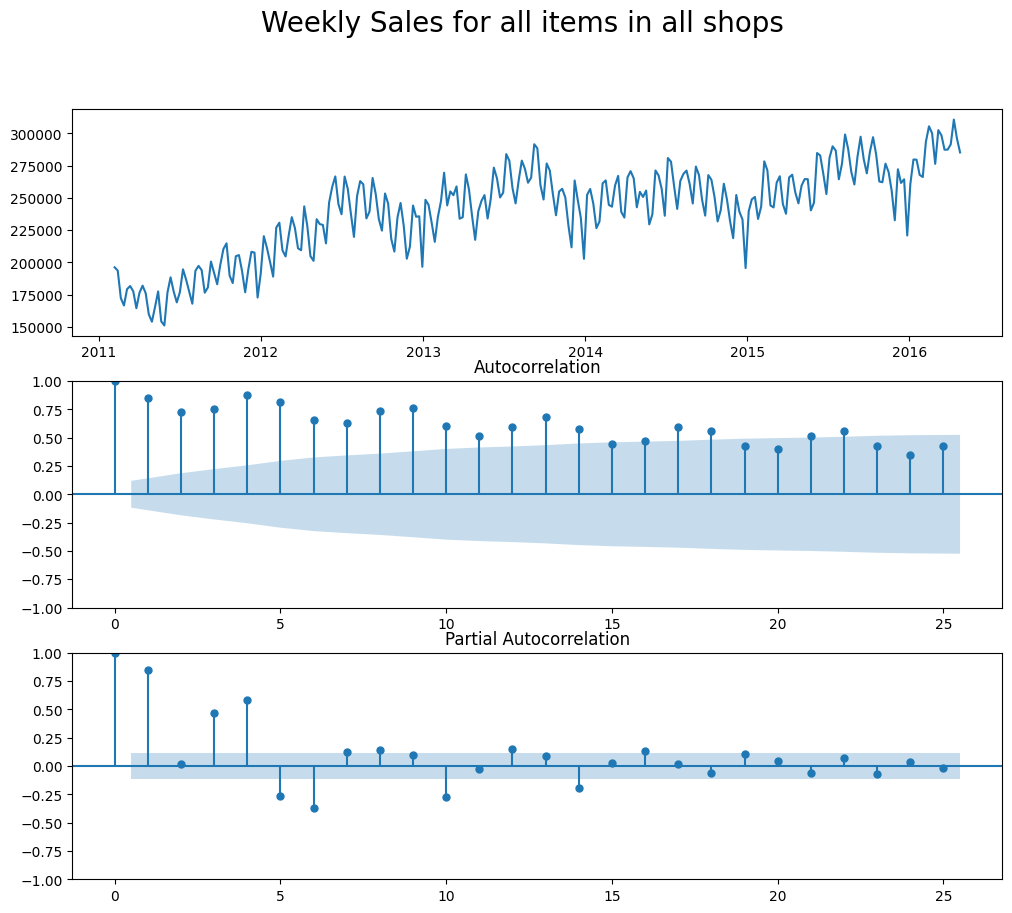

In [94]:
plot_ts_acf_pacf(y = y, title = "Weekly Sales for all items in all shops")

<Axes: xlabel='REGION'>

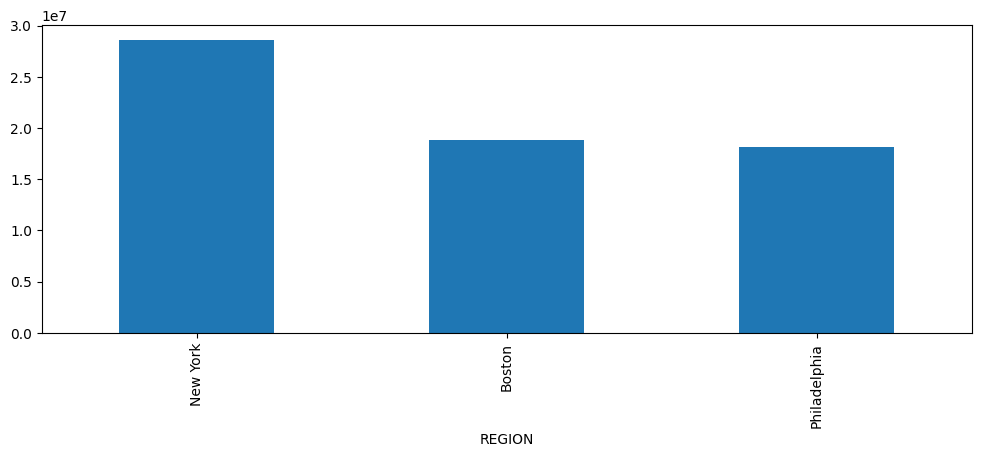

In [95]:
(
    df.
    groupby(["REGION"])
    ["WEEKLY_SALES"].sum()
    .sort_values(ascending = False)
    .plot(kind = "bar", figsize = (12, 4))
)

<Axes: xlabel='ITEM_CATEGORY'>

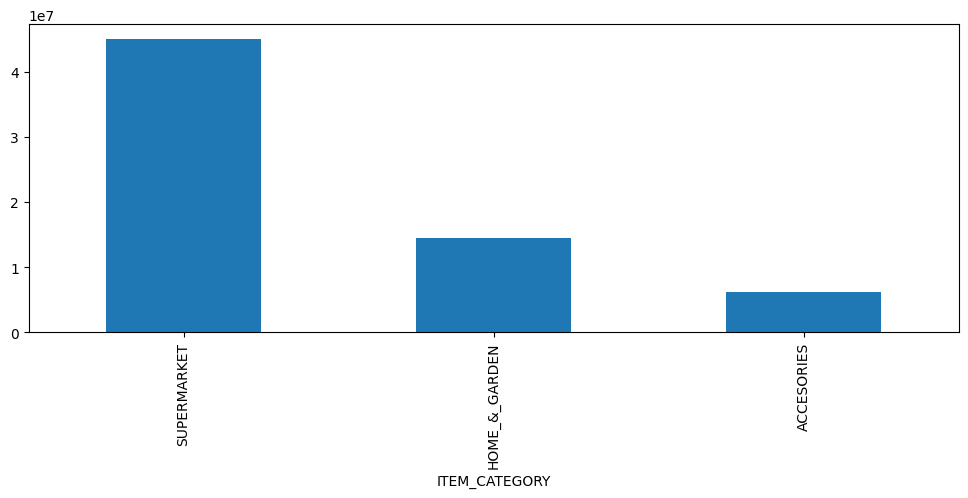

In [96]:
(
    df.
    groupby(["ITEM_CATEGORY"])
    ["WEEKLY_SALES"].sum()
    .sort_values(ascending = False)
    .plot(kind = "bar", figsize = (12, 4))
)

<Axes: xlabel='STORE'>

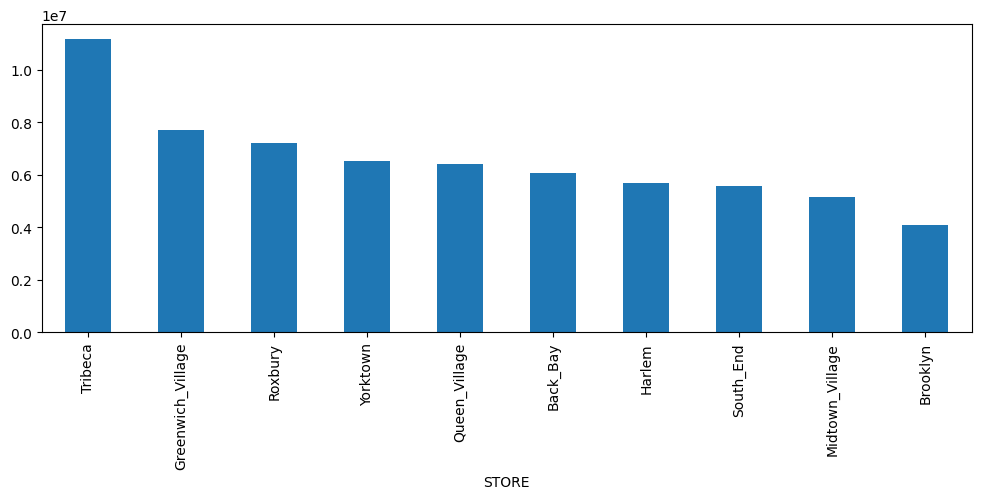

In [97]:
(
    df.
    groupby(["STORE"])
    ["WEEKLY_SALES"].sum()
    .sort_values(ascending = False)
    .plot(kind = "bar", figsize = (12, 4))
)

In [98]:
df.head()

,ID,DATE,ITEM,ITEM_CATEGORY,ITEM_DEPARTMENT,STORE_CODE,REGION,STORE,WEEKLY_SALES,EVENT_NEWYEAR,...,ITEM_CATEGORY_ID,ITEM_DEPARTMENT_ID,REGION_ID,STORE_ID,ITEM_ID,UNIQUE_DAYS_WITH_SALES,TOTAL_TRANSACTIONS,YEAR,MONTH,DAY
0,ACCESORIES_1_001_NYC_1,2011-02-06,ACCESORIES_1_001,ACCESORIES,ACCESORIES_1,NYC_1,New York,Greenwich_Village,0,False,...,0.0,0.0,1.0,2.0,0.0,2011-02-06,0,2011,2,6
1,ACCESORIES_1_001_NYC_1,2011-02-13,ACCESORIES_1_001,ACCESORIES,ACCESORIES_1,NYC_1,New York,Greenwich_Village,0,False,...,0.0,0.0,1.0,2.0,0.0,2011-02-13,0,2011,2,13
2,ACCESORIES_1_001_NYC_1,2011-02-20,ACCESORIES_1_001,ACCESORIES,ACCESORIES_1,NYC_1,New York,Greenwich_Village,0,False,...,0.0,0.0,1.0,2.0,0.0,2011-02-20,0,2011,2,20
3,ACCESORIES_1_001_NYC_1,2011-02-27,ACCESORIES_1_001,ACCESORIES,ACCESORIES_1,NYC_1,New York,Greenwich_Village,0,False,...,0.0,0.0,1.0,2.0,0.0,2011-02-27,0,2011,2,27
4,ACCESORIES_1_001_NYC_1,2011-03-06,ACCESORIES_1_001,ACCESORIES,ACCESORIES_1,NYC_1,New York,Greenwich_Village,0,False,...,0.0,0.0,1.0,2.0,0.0,2011-03-06,0,2011,3,6


In [99]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8323770 entries, 0 to 8323769
Data columns (total 26 columns):
 #   Column                  Dtype         
---  ------                  -----         
 0   ID                      object        
 1   DATE                    datetime64[ns]
 2   ITEM                    object        
 3   ITEM_CATEGORY           object        
 4   ITEM_DEPARTMENT         object        
 5   STORE_CODE              object        
 6   REGION                  object        
 7   STORE                   object        
 8   WEEKLY_SALES            int64         
 9   EVENT_NEWYEAR           bool          
 10  EVENT_NONE              bool          
 11  EVENT_SUPERBOWL         bool          
 12  EVENT_THANKSGIVING      bool          
 13  EVENT_RAMADAN           bool          
 14  WEEKLY_MEAN_PRICE       float64       
 15  WEEKLY_REVENUE          float64       
 16  ITEM_CATEGORY_ID        float64       
 17  ITEM_DEPARTMENT_ID      float64       
 18  RE

In [100]:
df['WEEKLY_SALES'].describe()

count    8.323770e+06
mean     7.884772e+00
std      2.371291e+01
min      0.000000e+00
25%      0.000000e+00
50%      2.000000e+00
75%      7.000000e+00
max      3.976000e+03
Name: WEEKLY_SALES, dtype: float64

In [101]:
df["WEEKLY_SALES"] = np.clip(df["WEEKLY_SALES"], 0, 15)

In [102]:
def build_ts_vars(full_df, gb_list, target_column, agg_func, agg_func_name, num_of_lags=1, rolling = False, window = 3, verbose = True):
    
    assert gb_list[0] == "DATE", "First element must be date"
    
    new_name = "_".join(gb_list + [target_column] + [agg_func_name])
    
    if verbose: print(new_name)

    gb_df_ = full_df.groupby(gb_list)[target_column].apply(agg_func).to_frame().reset_index().rename(
        columns = {
            target_column : new_name
        }
    )
    if rolling:
        gb_df_[f"{new_name}_MA"+f"{window}"] = gb_df_.groupby(gb_list[1:])[new_name].transform(
        lambda series: series.shift(1).rolling(window = window).mean()
    )
    else:    
        gb_df_[f"{new_name}_LAG{num_of_lags}"] = gb_df_.groupby(gb_list[1:])[new_name].transform(
                lambda series: series.shift(num_of_lags)
        )
    gb_df_.drop(new_name, axis=1, inplace=True)
    return gb_df_

In [103]:
GB_LIST_STORE_ID = ["DATE", "STORE_ID"]
TARGET_COLUMN = "WEEKLY_SALES"
AGG_FUNC = np.mean
AGG_FUNC_NAME = "MEAN"

week_sales_mean_ma = build_ts_vars(
    full_df = df,
    gb_list = GB_LIST_STORE_ID,
    target_column = TARGET_COLUMN,
    agg_func = AGG_FUNC,
    agg_func_name =  AGG_FUNC_NAME,
    rolling = True
)

week_sales_mean_ma.sample(10)

DATE_STORE_ID_WEEKLY_SALES_MEAN


,DATE,STORE_ID,DATE_STORE_ID_WEEKLY_SALES_MEAN_MA3
1837,2014-08-10,7.0,4.191757
2105,2015-02-15,5.0,4.154258
1961,2014-11-09,1.0,4.124959
929,2012-11-11,9.0,3.692358
2223,2015-05-10,3.0,4.165409
2056,2015-01-11,6.0,4.413250
1081,2013-03-03,1.0,3.309391
691,2012-06-03,1.0,3.059692
74,2011-03-27,4.0,2.434350
1842,2014-08-17,2.0,5.706024


In [104]:
GB_LIST_STORE_ID = ["DATE", "STORE_ID"]
TARGET_COLUMN = "WEEKLY_SALES"
AGG_FUNC = np.sum
AGG_FUNC_NAME = "SUM"

week_sales_sum_ma = build_ts_vars(
    full_df = df,
    gb_list = GB_LIST_STORE_ID,
    target_column = TARGET_COLUMN,
    agg_func = AGG_FUNC,
    agg_func_name =  AGG_FUNC_NAME,
)

week_sales_sum_ma.sample(10)

DATE_STORE_ID_WEEKLY_SALES_SUM


,DATE,STORE_ID,DATE_STORE_ID_WEEKLY_SALES_SUM_LAG1
2206,2015-04-26,6.0,15872.0
2448,2015-10-11,8.0,22167.0
2087,2015-02-01,7.0,12943.0
1271,2013-07-14,1.0,11458.0
2011,2014-12-14,1.0,12522.0
2580,2016-01-17,0.0,15356.0
2121,2015-03-01,1.0,12416.0
358,2011-10-09,8.0,13949.0
1220,2013-06-09,0.0,11737.0
531,2012-02-12,1.0,9711.0


In [105]:
GB_LIST_REGION_ID = ["DATE", "REGION_ID"]
TARGET_COLUMN = "WEEKLY_SALES"
AGG_FUNC = np.sum
AGG_FUNC_NAME = "SUM"

week_sales_region_sum_ma = build_ts_vars(
    full_df = df,
    gb_list = GB_LIST_REGION_ID,
    target_column = TARGET_COLUMN,
    agg_func = AGG_FUNC,
    agg_func_name =  AGG_FUNC_NAME,
)

week_sales_region_sum_ma.sample(10)

DATE_REGION_ID_WEEKLY_SALES_SUM


,DATE,REGION_ID,DATE_REGION_ID_WEEKLY_SALES_SUM_LAG1
362,2013-05-26,2.0,36979.0
574,2014-10-05,1.0,63144.0
551,2014-08-10,2.0,42280.0
731,2015-10-04,2.0,44790.0
81,2011-08-14,0.0,28827.0
608,2014-12-21,2.0,42808.0
15,2011-03-13,0.0,27661.0
348,2013-04-28,0.0,37110.0
355,2013-05-12,1.0,57047.0
275,2012-11-04,2.0,31836.0


In [106]:
GB_LIST_CAT_ID = ["DATE", "ITEM_CATEGORY_ID"]
TARGET_COLUMN = "WEEKLY_SALES"
AGG_FUNC = np.sum
AGG_FUNC_NAME = "SUM"

week_sales_cat_sum = build_ts_vars(
    full_df = df,
    gb_list = GB_LIST_CAT_ID,
    target_column = TARGET_COLUMN,
    agg_func = AGG_FUNC,
    agg_func_name =  AGG_FUNC_NAME
)

week_sales_cat_sum.sample(10)

DATE_ITEM_CATEGORY_ID_WEEKLY_SALES_SUM


,DATE,ITEM_CATEGORY_ID,DATE_ITEM_CATEGORY_ID_WEEKLY_SALES_SUM_LAG1
780,2016-01-31,0.0,19095.0
175,2012-03-18,1.0,30045.0
22,2011-03-27,1.0,24181.0
137,2011-12-18,2.0,64394.0
794,2016-02-28,2.0,102301.0
37,2011-05-01,1.0,24231.0
431,2013-11-03,2.0,79721.0
786,2016-02-14,0.0,20420.0
130,2011-12-04,1.0,24735.0
167,2012-02-26,2.0,66457.0


In [107]:
rows_before_merge = df.shape[0]
print(f"Shape before merge is {rows_before_merge}")

full_df = pd.merge(df, week_sales_mean_ma, on = GB_LIST_STORE_ID, how = "left")
full_df = pd.merge(full_df, week_sales_sum_ma, on = GB_LIST_STORE_ID, how = "left")
full_df = pd.merge(full_df, week_sales_region_sum_ma, on = GB_LIST_REGION_ID, how = "left")
full_df = pd.merge(full_df, week_sales_cat_sum, on = GB_LIST_CAT_ID, how = "left")

rows_after_merge = full_df.shape[0]

print(f"Shape after merge is {rows_after_merge}")

assert rows_before_merge == rows_after_merge, "You have generated a cartesian product!"

Shape before merge is 8323770
Shape after merge is 8323770


In [108]:
COLUMNS_TO_DROP = [
    'WEEKLY_REVENUE',
    'UNIQUE_DAYS_WITH_SALES',
    'TOTAL_TRANSACTIONS',
    'ITEM',
    'ITEM_CATEGORY',
    'ITEM_DEPARTMENT',
    'REGION',
    'STORE',
    'STORE_CODE'
]

full_df.drop(COLUMNS_TO_DROP, inplace = True, axis = 1)

In [109]:
full_df.set_index("ID", inplace = True)

In [110]:
full_df.sample(5)

,DATE,WEEKLY_SALES,EVENT_NEWYEAR,EVENT_NONE,EVENT_SUPERBOWL,EVENT_THANKSGIVING,EVENT_RAMADAN,WEEKLY_MEAN_PRICE,ITEM_CATEGORY_ID,ITEM_DEPARTMENT_ID,REGION_ID,STORE_ID,ITEM_ID,YEAR,MONTH,DAY,DATE_STORE_ID_WEEKLY_SALES_MEAN_MA3,DATE_STORE_ID_WEEKLY_SALES_SUM_LAG1,DATE_REGION_ID_WEEKLY_SALES_SUM_LAG1,DATE_ITEM_CATEGORY_ID_WEEKLY_SALES_SUM_LAG1
ID,,,,,,,,,,,,,,,,,,,,
ACCESORIES_1_040_NYC_1,2015-06-07,0,False,False,False,False,False,17.2501,0.0,0.0,1.0,2.0,39.0,2015,6,7,6.049196,18535.0,67469.0,20034.0
SUPERMARKET_3_501_NYC_2,2011-11-06,15,False,False,False,False,False,0.9840,2.0,6.0,1.0,3.0,2725.0,2011,11,6,3.443533,10475.0,44507.0,57789.0
HOME_&_GARDEN_1_026_PHI_1,2015-08-23,8,False,False,False,False,False,3.5875,1.0,2.0,2.0,4.0,590.0,2015,8,23,5.356073,16007.0,45420.0,48864.0
ACCESORIES_1_372_PHI_2,2014-04-27,4,False,False,False,False,False,8.8844,0.0,0.0,2.0,9.0,363.0,2014,4,27,4.697824,13638.0,40373.0,16464.0
HOME_&_GARDEN_2_074_NYC_4,2015-07-05,5,False,False,False,False,True,1.2125,1.0,3.0,1.0,1.0,1170.0,2015,7,5,4.230567,12667.0,68434.0,45567.0


In [111]:
full_df.sample(5)

,DATE,WEEKLY_SALES,EVENT_NEWYEAR,EVENT_NONE,EVENT_SUPERBOWL,EVENT_THANKSGIVING,EVENT_RAMADAN,WEEKLY_MEAN_PRICE,ITEM_CATEGORY_ID,ITEM_DEPARTMENT_ID,REGION_ID,STORE_ID,ITEM_ID,YEAR,MONTH,DAY,DATE_STORE_ID_WEEKLY_SALES_MEAN_MA3,DATE_STORE_ID_WEEKLY_SALES_SUM_LAG1,DATE_REGION_ID_WEEKLY_SALES_SUM_LAG1,DATE_ITEM_CATEGORY_ID_WEEKLY_SALES_SUM_LAG1
ID,,,,,,,,,,,,,,,,,,,,
SUPERMARKET_3_463_PHI_1,2012-05-27,0,False,False,False,False,False,7.1760,2.0,6.0,2.0,4.0,2687.0,2012,5,27,2.690500,8178.0,28533.0,68861.0
ACCESORIES_1_039_NYC_3,2012-01-01,0,True,False,False,False,False,7.8204,0.0,0.0,1.0,8.0,38.0,2012,1,1,4.458183,12450.0,40051.0,11673.0
ACCESORIES_1_030_NYC_3,2012-04-29,0,False,False,False,False,False,1.0640,0.0,0.0,1.0,8.0,29.0,2012,4,29,4.913305,14459.0,47548.0,13318.0
SUPERMARKET_3_325_NYC_1,2015-02-08,0,False,False,False,False,False,3.0000,2.0,6.0,1.0,2.0,2549.0,2015,2,8,5.621187,17071.0,62404.0,87088.0
HOME_&_GARDEN_1_304_PHI_3,2011-08-07,0,False,False,False,False,True,2.4750,1.0,2.0,2.0,5.0,862.0,2011,8,7,3.198535,9335.0,22373.0,25528.0


In [112]:
train_index = sorted(list(full_df["DATE"].unique()))[:-8]

valida_index = sorted(list(full_df["DATE"].unique()))[-8:-4]

test_index = sorted(list(full_df["DATE"].unique()))[-4:]

In [113]:
X_train = full_df[full_df["DATE"].isin(train_index)].drop(['WEEKLY_SALES', "DATE"], axis=1)
Y_train = full_df[full_df["DATE"].isin(train_index)]['WEEKLY_SALES']

X_valida = full_df[full_df["DATE"].isin(valida_index)].drop(['WEEKLY_SALES', "DATE"], axis=1)
Y_valida = full_df[full_df["DATE"].isin(valida_index)]['WEEKLY_SALES']

X_test = full_df[full_df["DATE"].isin(test_index)].drop(['WEEKLY_SALES', "DATE"], axis = 1)
Y_test = full_df[full_df["DATE"].isin(test_index)]['WEEKLY_SALES']

In [114]:
X_test.to_csv('./data_dsmarket/X_test.csv')

In [135]:
df_test = pd.read_csv('./data_dsmarket/X_test.csv')

The history saving thread hit an unexpected error (OperationalError('database or disk is full')).History will not be written to the database.


In [137]:
df_test

,ID,EVENT_NEWYEAR,EVENT_NONE,EVENT_SUPERBOWL,EVENT_THANKSGIVING,EVENT_RAMADAN,WEEKLY_MEAN_PRICE,ITEM_CATEGORY_ID,ITEM_DEPARTMENT_ID,REGION_ID,STORE_ID,ITEM_ID,YEAR,MONTH,DAY,DATE_STORE_ID_WEEKLY_SALES_MEAN_MA3,DATE_STORE_ID_WEEKLY_SALES_SUM_LAG1,DATE_REGION_ID_WEEKLY_SALES_SUM_LAG1,DATE_ITEM_CATEGORY_ID_WEEKLY_SALES_SUM_LAG1
0,ACCESORIES_1_001_NYC_1,False,False,False,False,False,10.9858,0.0,0.0,1.0,2.0,0.0,2016,4,3,6.172188,18671.0,75310.0,19960.0
1,ACCESORIES_1_001_NYC_1,False,False,False,False,False,10.9858,0.0,0.0,1.0,2.0,0.0,2016,4,10,6.216246,19434.0,77227.0,21319.0
2,ACCESORIES_1_001_NYC_1,False,False,False,False,False,11.1454,0.0,0.0,1.0,2.0,0.0,2016,4,17,6.340439,19891.0,78734.0,21311.0
3,ACCESORIES_1_001_NYC_1,False,False,False,False,False,11.1454,0.0,0.0,1.0,2.0,0.0,2016,4,24,6.345796,18720.0,75706.0,21002.0
4,ACCESORIES_1_002_NYC_1,False,False,False,False,False,5.2801,0.0,0.0,1.0,2.0,1.0,2016,4,3,6.172188,18671.0,75310.0,19960.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
121955,SUPERMARKET_3_826_PHI_3,False,False,False,False,False,1.5360,2.0,6.0,2.0,5.0,3047.0,2016,4,24,5.307751,16169.0,53361.0,106835.0
121956,SUPERMARKET_3_827_PHI_3,False,False,False,False,False,1.2000,2.0,6.0,2.0,5.0,3048.0,2016,4,3,5.061004,14530.0,49240.0,102855.0
121957,SUPERMARKET_3_827_PHI_3,False,False,False,False,False,1.2000,2.0,6.0,2.0,5.0,3048.0,2016,4,10,5.007106,15779.0,52452.0,103137.0
121958,SUPERMARKET_3_827_PHI_3,False,False,False,False,False,1.2000,2.0,6.0,2.0,5.0,3048.0,2016,4,17,5.128567,16602.0,54997.0,109718.0


In [115]:
X_test

,EVENT_NEWYEAR,EVENT_NONE,EVENT_SUPERBOWL,EVENT_THANKSGIVING,EVENT_RAMADAN,WEEKLY_MEAN_PRICE,ITEM_CATEGORY_ID,ITEM_DEPARTMENT_ID,REGION_ID,STORE_ID,ITEM_ID,YEAR,MONTH,DAY,DATE_STORE_ID_WEEKLY_SALES_MEAN_MA3,DATE_STORE_ID_WEEKLY_SALES_SUM_LAG1,DATE_REGION_ID_WEEKLY_SALES_SUM_LAG1,DATE_ITEM_CATEGORY_ID_WEEKLY_SALES_SUM_LAG1
ID,,,,,,,,,,,,,,,,,,
ACCESORIES_1_001_NYC_1,False,False,False,False,False,10.9858,0.0,0.0,1.0,2.0,0.0,2016,4,3,6.172188,18671.0,75310.0,19960.0
ACCESORIES_1_001_NYC_1,False,False,False,False,False,10.9858,0.0,0.0,1.0,2.0,0.0,2016,4,10,6.216246,19434.0,77227.0,21319.0
ACCESORIES_1_001_NYC_1,False,False,False,False,False,11.1454,0.0,0.0,1.0,2.0,0.0,2016,4,17,6.340439,19891.0,78734.0,21311.0
ACCESORIES_1_001_NYC_1,False,False,False,False,False,11.1454,0.0,0.0,1.0,2.0,0.0,2016,4,24,6.345796,18720.0,75706.0,21002.0
ACCESORIES_1_002_NYC_1,False,False,False,False,False,5.2801,0.0,0.0,1.0,2.0,1.0,2016,4,3,6.172188,18671.0,75310.0,19960.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
SUPERMARKET_3_826_PHI_3,False,False,False,False,False,1.5360,2.0,6.0,2.0,5.0,3047.0,2016,4,24,5.307751,16169.0,53361.0,106835.0
SUPERMARKET_3_827_PHI_3,False,False,False,False,False,1.2000,2.0,6.0,2.0,5.0,3048.0,2016,4,3,5.061004,14530.0,49240.0,102855.0
SUPERMARKET_3_827_PHI_3,False,False,False,False,False,1.2000,2.0,6.0,2.0,5.0,3048.0,2016,4,10,5.007106,15779.0,52452.0,103137.0


In [116]:
model = xgb.XGBRegressor(eval_metric = "rmse", early_stopping_rounds = 10, seed = 175)

model_name = str(model).split("(")[0]

day = str(datetime.now()).split()[0].replace("-", "_")
hour = str(datetime.now()).split()[1].replace(":", "_").split(".")[0]
t = str(day) + "_" + str(hour)

model.fit(X_train, Y_train, 
    eval_set = [(X_train, Y_train), (X_valida, Y_valida)], 
    verbose = True)

[0]	validation_0-rmse:5.73853	validation_1-rmse:6.28603
[1]	validation_0-rmse:5.27527	validation_1-rmse:5.54827
[2]	validation_0-rmse:5.02202	validation_1-rmse:5.10799
[3]	validation_0-rmse:4.88770	validation_1-rmse:4.87547
[4]	validation_0-rmse:4.81121	validation_1-rmse:4.74279
[5]	validation_0-rmse:4.75381	validation_1-rmse:4.65527
[6]	validation_0-rmse:4.72702	validation_1-rmse:4.59739
[7]	validation_0-rmse:4.70741	validation_1-rmse:4.56414
[8]	validation_0-rmse:4.69273	validation_1-rmse:4.54556
[9]	validation_0-rmse:4.68396	validation_1-rmse:4.53074
[10]	validation_0-rmse:4.67518	validation_1-rmse:4.51794
[11]	validation_0-rmse:4.65665	validation_1-rmse:4.50312
[12]	validation_0-rmse:4.65041	validation_1-rmse:4.50014
[13]	validation_0-rmse:4.64693	validation_1-rmse:4.49574
[14]	validation_0-rmse:4.64071	validation_1-rmse:4.48691
[15]	validation_0-rmse:4.62819	validation_1-rmse:4.47858
[16]	validation_0-rmse:4.62247	validation_1-rmse:4.47447
[17]	validation_0-rmse:4.61884	validation

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=10,
             enable_categorical=False, eval_metric='rmse', feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=100, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=None, ...)

In [134]:
pickle.dump(model, open("./data_dsmarket/modelos/{}_{}.pkl".format(model_name, t), "wb"))
print("{}_{}.pkl".format(model_name, t))

XGBRegressor_2023_05_17_03_16_40.dat


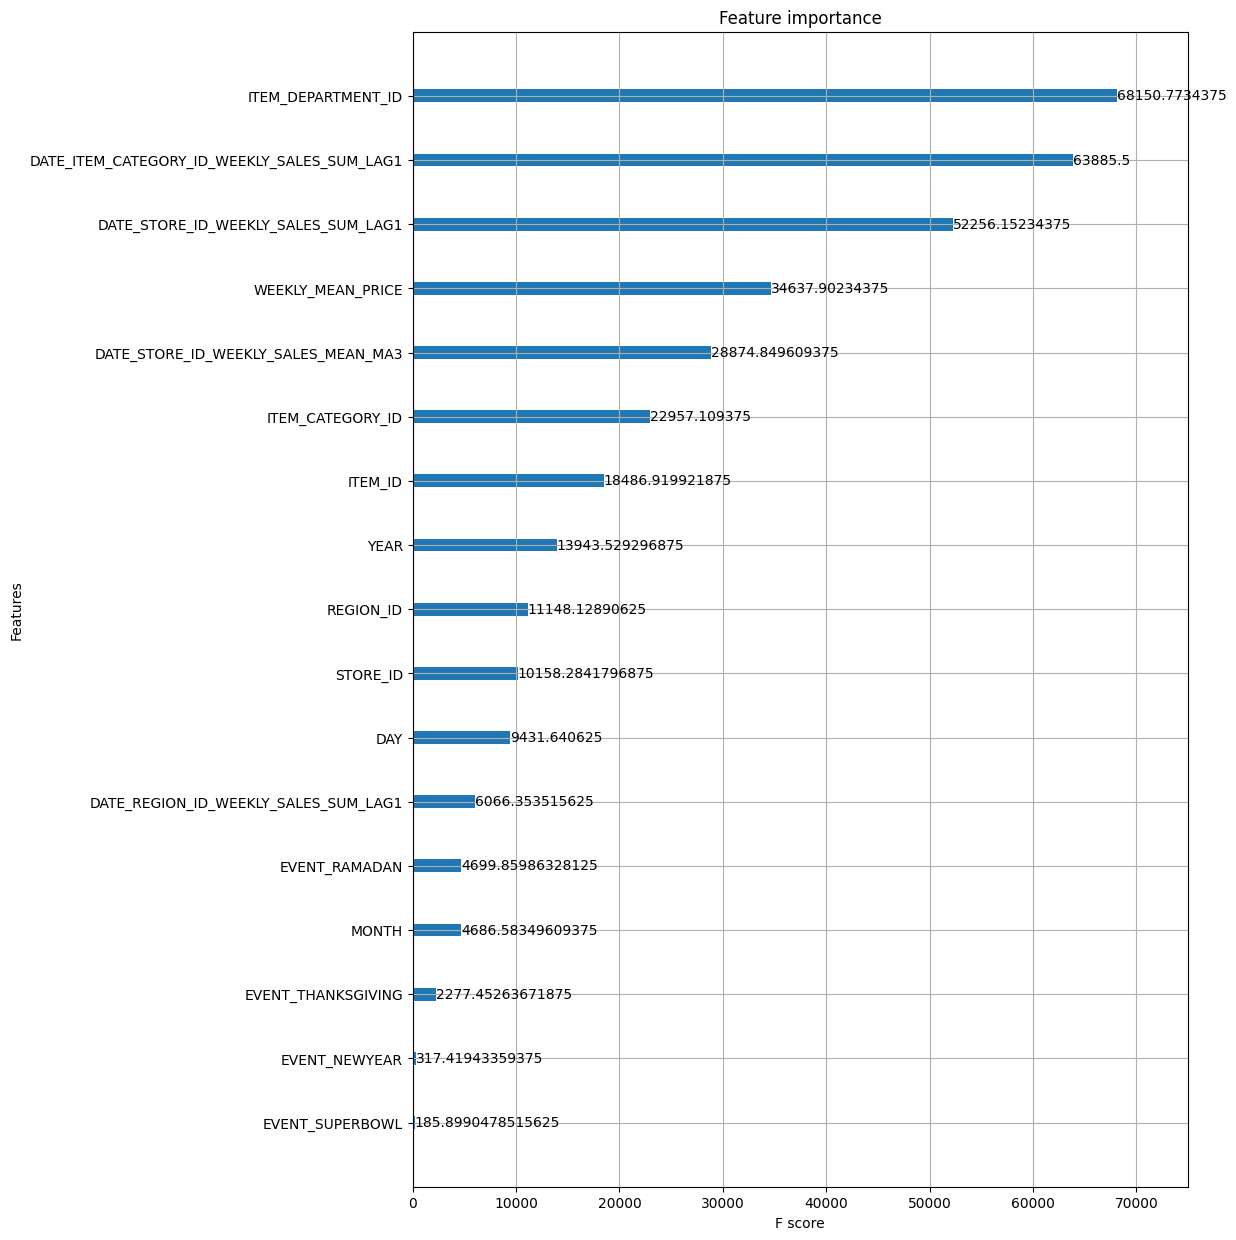

In [118]:
importance = model.get_booster().get_score(importance_type = "gain")
importance = {k: v for k, v in sorted(importance.items(), key = lambda item: item[1])}

fig, ax = plt.subplots(figsize = (10, 15))
xgb.plot_importance(model, importance_type = "gain", ax = ax);

In [119]:
Y_valida_pred = model.predict(X_valida)

rmse_valida = np.sqrt(mean_squared_error(Y_valida, Y_valida_pred))
rmse_valida

4.186957069448304

In [120]:
predictions = model.predict(X_test)
X_test["SALES_PREDICTED"] = np.clip(predictions, 0, 15)

In [121]:
last_trained_model = pickle.load(open("./data_dsmarket/modelos/{}_{}.dat".format(model_name, t), "rb"))

In [122]:
Y_test

ID
ACCESORIES_1_001_NYC_1      2
ACCESORIES_1_001_NYC_1     12
ACCESORIES_1_001_NYC_1      5
ACCESORIES_1_001_NYC_1      8
ACCESORIES_1_002_NYC_1      1
                           ..
SUPERMARKET_3_826_PHI_3     8
SUPERMARKET_3_827_PHI_3    15
SUPERMARKET_3_827_PHI_3     8
SUPERMARKET_3_827_PHI_3     0
SUPERMARKET_3_827_PHI_3     0
Name: WEEKLY_SALES, Length: 121960, dtype: int64

In [123]:
predictions.sum()

703279.25

In [124]:
from sklearn.metrics import mean_squared_error

rms = mean_squared_error(Y_test, X_test['SALES_PREDICTED'], squared=False)

In [125]:
rms

4.154948625694851

In [126]:
X_test['DATE'] = full_df[full_df["DATE"].isin(test_index)]["DATE"]

In [127]:
X_test.info()

<class 'pandas.core.frame.DataFrame'>
Index: 121960 entries, ACCESORIES_1_001_NYC_1 to SUPERMARKET_3_827_PHI_3
Data columns (total 20 columns):
 #   Column                                       Non-Null Count   Dtype         
---  ------                                       --------------   -----         
 0   EVENT_NEWYEAR                                121960 non-null  bool          
 1   EVENT_NONE                                   121960 non-null  bool          
 2   EVENT_SUPERBOWL                              121960 non-null  bool          
 3   EVENT_THANKSGIVING                           121960 non-null  bool          
 4   EVENT_RAMADAN                                121960 non-null  bool          
 5   WEEKLY_MEAN_PRICE                            121960 non-null  float64       
 6   ITEM_CATEGORY_ID                             121960 non-null  float64       
 7   ITEM_DEPARTMENT_ID                           121960 non-null  float64       
 8   REGION_ID                      

In [128]:
df[df['REGION_ID'] == 1.0]['REGION'].unique()

array(['New York'], dtype=object)

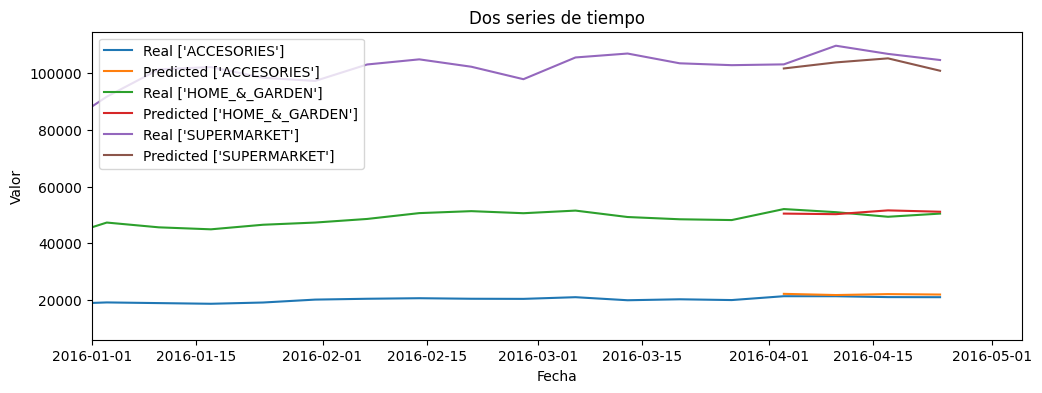

In [129]:
plt.figure(figsize = (12, 4))
# Plotear ambas series en una misma gráfica
for department in full_df['ITEM_CATEGORY_ID'].unique():
    department_name = df[df['ITEM_CATEGORY_ID'] == department]['ITEM_CATEGORY'].unique()
    plt.plot(full_df['DATE'].unique(), full_df[full_df['ITEM_CATEGORY_ID'] == department].groupby('DATE')['WEEKLY_SALES'].sum(), label=f'Real {department_name}')
    plt.plot(X_test['DATE'].unique(), X_test[X_test['ITEM_CATEGORY_ID'] == department].groupby('DATE')["SALES_PREDICTED"].sum(), label=f'Predicted {department_name}')
   
# Configurar la gráfica
plt.xlabel('Fecha')
plt.ylabel('Valor')
plt.title('Dos series de tiempo')
plt.legend()
plt.xlim(pd.Timestamp('2016-01-01'), pd.Timestamp('2016-05-5'))
#plt.ylim(0, 15)

# Mostrar la gráfica
plt.show()

In [130]:
X_test

,EVENT_NEWYEAR,EVENT_NONE,EVENT_SUPERBOWL,EVENT_THANKSGIVING,EVENT_RAMADAN,WEEKLY_MEAN_PRICE,ITEM_CATEGORY_ID,ITEM_DEPARTMENT_ID,REGION_ID,STORE_ID,ITEM_ID,YEAR,MONTH,DAY,DATE_STORE_ID_WEEKLY_SALES_MEAN_MA3,DATE_STORE_ID_WEEKLY_SALES_SUM_LAG1,DATE_REGION_ID_WEEKLY_SALES_SUM_LAG1,DATE_ITEM_CATEGORY_ID_WEEKLY_SALES_SUM_LAG1,SALES_PREDICTED,DATE
ID,,,,,,,,,,,,,,,,,,,,
ACCESORIES_1_001_NYC_1,False,False,False,False,False,10.9858,0.0,0.0,1.0,2.0,0.0,2016,4,3,6.172188,18671.0,75310.0,19960.0,4.322840,2016-04-03
ACCESORIES_1_001_NYC_1,False,False,False,False,False,10.9858,0.0,0.0,1.0,2.0,0.0,2016,4,10,6.216246,19434.0,77227.0,21319.0,4.235953,2016-04-10
ACCESORIES_1_001_NYC_1,False,False,False,False,False,11.1454,0.0,0.0,1.0,2.0,0.0,2016,4,17,6.340439,19891.0,78734.0,21311.0,4.202130,2016-04-17
ACCESORIES_1_001_NYC_1,False,False,False,False,False,11.1454,0.0,0.0,1.0,2.0,0.0,2016,4,24,6.345796,18720.0,75706.0,21002.0,4.179446,2016-04-24
ACCESORIES_1_002_NYC_1,False,False,False,False,False,5.2801,0.0,0.0,1.0,2.0,1.0,2016,4,3,6.172188,18671.0,75310.0,19960.0,2.577028,2016-04-03
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
SUPERMARKET_3_826_PHI_3,False,False,False,False,False,1.5360,2.0,6.0,2.0,5.0,3047.0,2016,4,24,5.307751,16169.0,53361.0,106835.0,7.263225,2016-04-24
SUPERMARKET_3_827_PHI_3,False,False,False,False,False,1.2000,2.0,6.0,2.0,5.0,3048.0,2016,4,3,5.061004,14530.0,49240.0,102855.0,8.309577,2016-04-03
SUPERMARKET_3_827_PHI_3,False,False,False,False,False,1.2000,2.0,6.0,2.0,5.0,3048.0,2016,4,10,5.007106,15779.0,52452.0,103137.0,7.868874,2016-04-10


In [131]:
df.set_index('ID', inplace=True)

In [132]:
X_test = X_test.merge(df[['STORE', 'REGION', 'ITEM_CATEGORY', 'ITEM_DEPARTMENT']], how = 'left',  left_index=True, right_index=True)

In [133]:
result_cols = [
    'WEEKLY_MEAN_PRICE',
    'DATE',
    'STORE',
    'REGION',
    'ITEM_CATEGORY',
    'ITEM_DEPARTMENT',
    'SALES_PREDICTED'
] 
X_test = X_test[result_cols]